<a href="https://colab.research.google.com/github/florentPoux/point-cloud-processing/blob/main/Point_cloud_data_sub_sampling_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

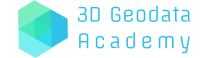

Created by Florent Poux. Licence MIT.
Members of the [3D Geodata Academy](https://learngeodata.eu) enrolled in a Course can use the code with Privileged IP Rights. 

*   To reuse in your project, please tag me on [Linkedin](https://www.linkedin.com/in/florent-poux-point-cloud/), [Medium](https://medium.com/@florentpoux) or [Twitter](https://twitter.com/PouxPointCloud).
*   Have fun with this notebook that you can very simply run (ctrl+Enter) !
*   The first time thought, it will ask you to get a key for it to be able to acces your Google drive folders if you want to work all remotely.
*   Simply accept, and then change the input path by the folder path containing your data, on Google Drive.

Enjoy!

# Step 1: Setting up the environment

In [ ]:
#This code snippet allows to use data directly from your Google drives files.
#If you want to use a shared folder, just add the folder to your drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Step 2: Load and prepare the data

In [ ]:
#https://pythonhosted.org/laspy/
!pip install laspy

#libraries used
import numpy as np
import laspy as lp


Mounted at /content/gdrive


In [ ]:
#create paths and load data
input_path="gdrive/My Drive/10-MEDIUM/DATA/Point Cloud Sample/"
output_path="gdrive/My Drive/10-MEDIUM/DATA/Point Cloud Sample/"

#Load the file
dataname="NZ19_Wellington"
point_cloud=lp.file.File(input_path+dataname+".las", mode="r")

#store coordinates in "points", and colors in "colors" variable
points = np.vstack((point_cloud.x, point_cloud.y, point_cloud.z)).transpose()
colors = np.vstack((point_cloud.red, point_cloud.green, point_cloud.blue)).transpose()

# Step 3: Choose a sub-sampling strategy

## 1- Point Cloud Decimation

In [ ]:
#The decimation strategy, by setting a decimation factor
factor=160
decimated_points = points[::factor]
#decimated_colors = colors[::factor]
len(decimated_points)

## 2 - Point Cloud voxel grid

In [ ]:
# Initialize the number of voxels to create to fill the space including every point
voxel_size=6
nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
#nb_vox.astype(int) #this gives you the number of voxels per axis

array([254, 154,  51])

In [ ]:
# Compute the non empty voxels and keep a trace of indexes that we can relate to points in order to store points later on.
# Also Sum and count the points in each voxel.
non_empty_voxel_keys, inverse, nb_pts_per_voxel= np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
idx_pts_vox_sorted=np.argsort(inverse)
#len(non_empty_voxel_keys) # if you need to display how many no-empty voxels you have

92090

In [ ]:
#Here, we loop over non_empty_voxel_keys numpy array to
#       > Store voxel indices as keys in a dictionnary
#       > Store the related points as the value of each key
#       > Compute each voxel barycenter and add it to a list
#       > Compute each voxel closest point to the barycenter and add it to a list

voxel_grid={}
grid_barycenter,grid_candidate_center=[],[]
last_seen=0

for idx,vox in enumerate(non_empty_voxel_keys):
  voxel_grid[tuple(vox)]=points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
  grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
  grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)]-np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
  last_seen+=nb_pts_per_voxel[idx]

# Step 4: Vizualise and export the results

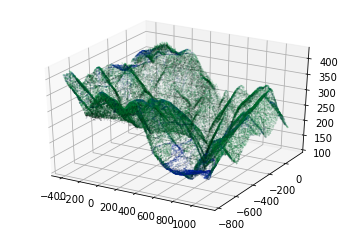

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.scatter(decimated_points[:,0], decimated_points[:,1], decimated_points[:,2], c = decimated_colors/65535, s=0.01)
plt.show()

In [ ]:
%timeit np.savetxt(output_path+dataname+"_voxel-best_point_%s.xyz" % (voxel_size), grid_candidate_center, delimiter=";", fmt="%s")

1 loop, best of 3: 405 ms per loop


# Step 5 - Automate with functions

In [ ]:
#Define a function that takes as input an array of points, and a voxel size expressed in meters. It returns the sampled point cloud
def grid_subsampling(points, voxel_size):
  non_empty_voxel_keys, inverse, nb_pts_per_voxel= np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
  idx_pts_vox_sorted=np.argsort(inverse)
  voxel_grid={}
  grid_barycenter,grid_candidate_center=[],[]
  last_seen=0

  for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]=points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)]-np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    last_seen+=nb_pts_per_voxel[idx]

  return grid_candidate_center

In [ ]:
#Execute the function, and store the results in the grid_sampled_point_cloud variable
grid_sampled_point_cloud variable = grid_subsampling(point_cloud, 6)

#Save the variable to an ASCII file to open in a 3D Software
%timeit np.savetxt(output_path+dataname+"_sampled.xyz", grid_sampled_point_cloud variable, delimiter=";", fmt="%s")